('Found and verified', u'.cache/train-images-idx3-ubyte.gz')
('Found and verified', u'.cache/t10k-images-idx3-ubyte.gz')
Extracting data for .cache/train-images-idx3-ubyte. This may take a while. Please wait.
Extracting data for .cache/t10k-images-idx3-ubyte. This may take a while. Please wait.


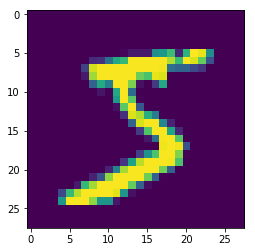

In [2]:
%matplotlib inline
import json
from IPython.display import display, Image

DATA_TYPES = {
    0x08: 'B',  # unsigned byte
    0x09: 'b',  # signed byte
    0x0b: 'h',  # short (2 bytes)
    0x0c: 'i',  # int (4 bytes)
    0x0d: 'f',  # float (4 bytes)
    0x0e: 'd'
}  # double (8 bytes)

CACHE_DIR = '.cache'
url  = 'http://yann.lecun.com/exdb/mnist/'
import matplotlib.pyplot as plt
from scipy import misc
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

import struct
import array
import numpy as np
import os
import operator
import sys
import functools
import gzip


last_percent_reported = None


def main ():
    with(open('config.json', 'r')) as f:
        config = json.load(f)

    train_filename_gz = maybe_download(config["train"]["images"], 9912422)
    test_filename_gz  = maybe_download(config["test"]["images"], 1648877)

    train_pickle = maybe_extract(train_filename_gz)
    test_pickle = maybe_extract(test_filename_gz)

    with open(train_pickle, 'rb') as tp:
        train_dataset = pickle.load(tp)

    with open(test_pickle, 'rb') as tp:
        test_dataset = pickle.load(tp)

    plt.imshow(train_dataset[0])        
    plt.show()


def download_progress_hook(count, blockSize, totalSize):
  global last_percent_reported

  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()

    last_percent_reported = percent

def maybe_download (filename, expected_bytes, force=False):
    dest_filename = os.path.join(CACHE_DIR, filename)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download:', filename)
        filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
        print('Download Complete!')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception('Failed to verify ' + dest_filename)
    return dest_filename

def extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]

fopen = gzip.open if os.path.splitext(filename)[1] == '.gz' else open

    with fopen(filename, 'rb') as fd:
        pickle_file = root + '.pickle'
        return maybe_pickle(pickle_file, parse_idx(fd), force)


def maybe_pickle(filename, data, force=False):
    if (not os.path.exists(filename) or force):
        with open(filename, 'wb') as pf:
            print 'pickling', filename
            pickle.dump(data, pf, pickle.HIGHEST_PROTOCOL)
    return filename

def parse_idx(fd):
    header = fd.read(4)
    if len(header) != 4:
        raise IdxDecodeError('Invalid IDX file, file empty or does not contain a full header.')

    zeros, data_type, num_dimensions = struct.unpack('>HBB', header)

    if zeros != 0:
        raise IdxDecodeError('Invalid IDX file, file must start with two zero bytes. '
                             'Found 0x%02x' % zeros)

    try:
        data_type = DATA_TYPES[data_type]
    except KeyError:
        raise IdxDecodeError('Unknown data type 0x%02x in IDX file' % data_type)

    dimension_sizes = struct.unpack('>' + 'I' * num_dimensions,
                                    fd.read(4 * num_dimensions))

    data = array.array(data_type, fd.read())
    data.byteswap()  # looks like array.array reads data as little endian

    expected_items = functools.reduce(operator.mul, dimension_sizes)
    if len(data) != expected_items:
        raise IdxDecodeError('IDX file has wrong number of items. '
                             'Expected: %d. Found: %d' % (expected_items, len(data)))
    return np.array(data).reshape(dimension_sizes)

if __name__ == '__main__':
    main()

